In [1]:
from langchain.llms import Ollama
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain.prompts import PromptTemplate
import pandas as pd
from dotenv import load_dotenv
import time
import re
import pandas as pd
import matplotlib.pyplot as plt

u:\Estudos\Projetos\rgbrain-labs\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
load_dotenv('../../.env')

True

In [3]:
llam3 = Ollama(model="llama3:8b")
gemini = ChatGoogleGenerativeAI(model="gemini-pro")

In [4]:
df_agendas = pd.read_csv("agendas.csv", sep=";")

print(df_agendas.head())

   ID_Cliente Data_Agenda                                            Agendas  \
0       12345  10/01/2024  Estou muito satisfeito com o atendimento, mas ...   
1       67890  10/01/2024  Estou decepcionado com a demora para ser conte...   
2       11111  15/01/2024  Amei o carro que consegui no consorcio, a expe...   
3       22222  15/01/2024  A empresa nao me respondeu sobre o meu pedido ...   
4       33333  15/01/2024  O sistema online do consorcio e muito facil de...   

   Idade     Genero          Cidade Estado             Profissao  Valor Renda  \
0     35  Masculino       Sao Paulo     SP            Engenheiro         5000   
1     42   Feminino  Rio de Janeiro     RJ            Professora         3500   
2     28  Masculino  Belo Horizonte     MG                Medico         7000   
3     50   Feminino        Curitiba     PR              Advogada         4500   
4     32  Masculino    Porto Alegre     RS  Analista de Sistemas         6000   

   Quantidade de Compras  NPS  Q

In [23]:
prompt_geral = """

<Entrada>
    {texto_da_agenda}
</Entrada>

Por favor, realize uma análise profunda e detalhada 
do sentimento expresso na frase delimitada por <Entrada></Entrada>, 
classificando-a como positiva, negativa ou neutra. 
Identifique e liste os sentimentos específicos presentes, 
em sua forma mais simples e direta (palavra primitiva) 
tanto explícitos quanto implícitos, e avalie a intensidade de cada sentimento de 0 (zero) a 100. 
Indique quais palavras-chave na sentença contribuíram 
para os sentimentos identificados. 
Em seguida, sugira possíveis razões para esses sentimentos 
com base no contexto da frase. Por fim, explique como você chegou 
a essas conclusões. Retorne todas essas informações 
no seguinte formato de um objeto JSON: 


    frase: frase analisada que está entre <Entrada></Entrada>
    classe: classe,
    sentimentos: 
        sentimento: intensidade
    ,
    contribuicoes: 
        palavra/frase: sentimento associado
        ,
    razoes_possiveis: [string],
    explicacao_modelo: string

"""

In [14]:
# Define um prompt para classificação de sentimento
prompt_sentimento = """
Assistente Sentimento

Você é um assistente inteligente de análise de texto especializado em interpretar textos de 
agenda do ERP para fornecer insights acionáveis para a equipe comercial no setor de consórcios. 
Sua tarefa é analisar o texto fornecido e identificar o sentimento expressado pelo cliente, 
considerando as nuances e complexidades da linguagem.

<Entrada>
    {texto_da_agenda}
</Entrada>

<Saída_Esperada>
    A saída deve ser um dos seguintes sentimentos
        - Positivo
        - Negativo
        - Neutro
        - Ambivalente
        - Não mencionado
</Saída_Esperada>

<Exemplos>
    <Exemplo>
        <Entrada>
            Estou muito satisfeito com o serviço. A qualidade do produto é excelente e o suporte 
            técnico é muito rápido e eficiente.
        </Entrada>
        <Saída>
            Positivo
        </Saída>
    </Exemplo>
    <Exemplo>
        <Entrada>
            Estou frustrado com o serviço. A qualidade do produto caiu muito e o 
            suporte técnico demora muito para responder.
        </Entrada>
        <Saída>
            Negativo
        </Saída>
    </Exemplo>
    <Exemplo>
        <Entrada>
            Estou contente com o valor das parcelas, mas o tempo de espera para a 
            contemplação está me deixando um pouco ansioso.
        </Entrada>
        <Saída>
            Ambivalente
        </Saída>
    </Exemplo>
    <Exemplo>
        <Entrada>
            O cliente não mencionou seu sentimento sobre o serviço.
        </Entrada>
        <Saída>
            Não mencionado
        </Saída>
    </Exemplo>
</Exemplos>

<Instruções_Adicionais>
    - Use exemplos específicos do texto fornecido para apoiar sua classificação e descrição.
    - Identifique o sentimento predominante, mesmo que o texto contenha opiniões contrastantes.
    - Se a informação necessária não estiver presente no texto, indique "Não mencionado".
    - Você deve retornar somente o sentimento, não é necessário opinar ou dizer qualquer outra coisa.
</Instruções_Adicionais>
"""

# Define um prompt para identificação de intenção
prompt_intencao = """
Assistente Intenção

Você é um assistente inteligente de análise de texto especializado em interpretar textos 
de agenda do ERP para fornecer insights acionáveis para a equipe comercial no setor de 
consórcios. Sua tarefa é analisar o texto fornecido e identificar a intenção expressada 
pelo cliente, considerando as nuances da linguagem e as particularidades do setor.

<Entrada>
    {texto_da_agenda}
</Entrada>

<Saída_Esperada>
    A saída deve ser um dos seguintes sentimentos
        [Cancelamento, Redução de Investimento, Retorno no Futuro, Mudança de Plano, Dúvida, Outro]
</Saída_Esperada>

<Exemplos>
    <Exemplo>
        <Entrada>
            Gostaria de cancelar meu serviço porque não estou mais satisfeito com ele.
        </Entrada>
        <Saída>
            Cancelamento
        </Saída>
    </Exemplo>
    <Exemplo>
        <Entrada>
            Estou pensando em reduzir o valor que invisto no serviço porque preciso cortar custos.
        </Entrada>
        <Saída>
            Redução de Investimento
        </Saída>
    </Exemplo>
    <Exemplo>
        <Entrada>
            Talvez eu volte a usar o serviço no próximo ano, mas agora não posso continuar.
        </Entrada>
        <Saída>
            Retorno no Futuro
        </Saída>
    </Exemplo>
    <Exemplo>
        <Entrada>
            Estou interessado em mudar para um plano que ofereça mais benefícios.
        </Entrada>
        <Saída>
            Mudança de Plano
        </Saída>
    </Exemplo>
    <Exemplo>
        <Entrada>
            Tenho algumas dúvidas sobre o funcionamento do serviço.
        </Entrada>
        <Saída>
            Dúvida
        </Saída>
    </Exemplo>
    <Exemplo>
        <Entrada>
            Avise-me quando a minha cota estiver perto de ser contemplada.
        </Entrada>
        <Saída>
            Outro
        </Saída>
    </Exemplo>  
</Exemplos>
    

<Instruções_Adicionais>
    - Use exemplos específicos do texto fornecido para apoiar sua classificação e descrição.
    - Se a informação necessária não estiver presente no texto, indique "Não mencionado".
    - Identifique a intenção predominante, mesmo que o texto contenha informações ambíguas ou múltiplas intenções.
    - Você deve retornar somente a intenção, não é necessário opinar ou dizer qualquer outra coisa.
</Instruções_Adicionais>

"""

# Define um prompt para extração de motivos
prompt_motivos = """
Assistente Motivo

Você é um assistente inteligente de análise de texto especializado em interpretar textos de 
agenda do ERP para fornecer insights acionáveis para a equipe comercial **no setor de consórcios**. 
Sua tarefa é analisar o texto fornecido e identificar os motivos mencionados pelo cliente 
que levaram à intenção de {intencao}. Siga estas etapas:

<Entrada>
    {texto_da_agenda}
</Entrada>

<Saída_Esperada>
É necessário retornar todo os motivos com ao menos uma classificação

Motivos Relacionados ao Produto/Serviço:
    Classifique os problemas específicos relacionados ao produto ou serviço mencionados 
    pelo cliente seguindo as seguintes opções:
    Valor das Parcelas, Tempo de Espera para Contemplação, Falta de Flexibilidade na Escolha de Bens, Não mencionado
Motivos Relacionados ao Atendimento:
    Classifique quaisquer problemas específicos relacionados ao atendimento ao cliente mencionados 
    pelo cliente seguindo as seguintes opções:
    Falta de Informação, Demora no Atendimento, Não mencionado
Motivos Relacionados à Experiência do Cliente:
    Classifique quaisquer problemas específicos relacionados à experiência do cliente 
    mencionados pelo cliente seguindo as seguintes opções: 
    Dificuldade em Acessar o Sistema, Falta de Clareza nas Informações, Não mencionado
Motivos Externos:
    Classifique quaisquer fatores externos mencionados pelo cliente seguindo as seguintes opções:
    Dificuldades Financeiras, Mudança de planos, Não mencionado
</Saída_Esperada>

<Exemplos>
    <Exemplo>
        <Entrada>
            Estou cancelando o serviço porque a qualidade do produto caiu muito e o 
            suporte técnico demora muito para responder. Além disso, encontrei uma 
            oferta melhor da concorrência.
        </Entrada>
        <Saída>
            Motivos Relacionados ao Produto/Serviço: A qualidade do produto caiu.
            Motivos Relacionados ao Atendimento: O suporte técnico demora muito para responder.
            Motivos Relacionados à Experiência do Cliente: Não mencionado.
            Motivos Externos: Encontrou uma oferta melhor da concorrência.
        </Saída>
    </Exemplo>
    <Exemplo>
        <Entrada>
           Preciso reduzir meu investimento porque estou cortando custos na empresa e o retorno 
            sobre o investimento não está sendo satisfatório. Além disso, o tempo de espera 
            para contemplação está muito longo.
        </Entrada>
        <Saída>
            Motivos Relacionados ao Produto/Serviço: O retorno sobre o investimento não está sendo satisfatório. O tempo de espera para contemplação está muito longo.
            Motivos Relacionados ao Atendimento: Não mencionado.
            Motivos Relacionados à Experiência do Cliente: Não mencionado.
            Motivos Externos: Está cortando custos na empresa.
        </Saída>
    </Exemplo>
</Exemplos>


<Instruções_Adicionais>    
    - Use exemplos específicos do texto fornecido para apoiar sua classificação e descrição.    
    - Você deve retornar somente os quatro motivos e suas opções, não é necessário opinar ou dizer qualquer outra coisa.
    - Se atente ao formato de retorno, ele não seve ser diferente do que foi fornecido.
<Instruções_Adicionais>
"""

In [24]:
template_sentimento = PromptTemplate(
    input_variables=["texto_da_agenda"],
    template=prompt_sentimento,
)

template_geral = PromptTemplate(
    input_variables=["texto_da_agenda"],
    template=prompt_geral,
)

template_intencao = PromptTemplate(
    input_variables=["texto_da_agenda"],
    template=prompt_intencao,
)

template_motivos = PromptTemplate(
    input_variables=["intencao", "texto_da_agenda"],
    template=prompt_motivos,
)



In [25]:
chain_sentimento = template_sentimento | gemini
chain_intencao = template_intencao | gemini
chain_motivos = template_motivos | gemini
chain_geral = template_geral | gemini

In [17]:
df_agendas['Sentimento'] = ''
df_agendas['Intenção'] = ''
df_agendas['Motivos_Produto_Serviço'] = ''
df_agendas['Motivos_Atendimento'] = ''
df_agendas['Motivos_Experiencia'] = ''
df_agendas['Motivos_Externos'] = ''

In [18]:
# Limite de requisições por minuto (ex: 15 chamadas)
limite_requisicoes = 15
tempo_por_requisicao = 60 / limite_requisicoes # Tempo em segundos por requisição

In [ ]:
for index, row in df_agendas.iterrows():    
    texto_da_agenda = row['Agendas']

    # Espera o tempo necessário para a próxima requisição
    time.sleep(tempo_por_requisicao)

    # Análise de Sentimento  
    resposta_sentimento = chain_sentimento.invoke(texto_da_agenda)
    df_agendas.loc[index, 'Sentimento'] = resposta_sentimento.content.strip() 

    print('### SENTIMENTO ###')
    print(resposta_sentimento.content)

    # Espera o tempo necessário para a próxima requisição
    time.sleep(tempo_por_requisicao)

    # Análise de Intenção
    resposta_intencao = chain_intencao.invoke(texto_da_agenda)
    df_agendas.loc[index, 'Intenção'] = resposta_intencao.content.strip()
    
    print('### INTENÇÃO ###')
    print(resposta_intencao.content)

    # Espera o tempo necessário para a próxima requisição
    time.sleep(tempo_por_requisicao)

    # Análise de Motivos
    resposta_motivos = chain_motivos.invoke({"intencao": resposta_intencao.content, "texto_da_agenda": texto_da_agenda})
    resposta_motivos = resposta_motivos.content.replace("*", "").replace("[", "").replace("]", "")    
    
    print('### MOTIVO ###')
    print(resposta_motivos)
    print('\n\n ---------------------------------------------')

    # Extrai os motivos de cada categoria   
    df_agendas.loc[index, 'Motivos_Produto_Serviço'] = resposta_motivos.split('Motivos Relacionados ao Produto/Serviço:')[1].split('Motivos Relacionados ao Atendimento:')[0].strip()
    df_agendas.loc[index, 'Motivos_Atendimento'] = resposta_motivos.split('Motivos Relacionados ao Atendimento:')[1].split('Motivos Relacionados à Experiência do Cliente:')[0].strip()
    df_agendas.loc[index, 'Motivos_Experiencia'] = resposta_motivos.split('Motivos Relacionados à Experiência do Cliente:')[1].split('Motivos Externos:')[0].strip()
    df_agendas.loc[index, 'Motivos_Externos'] = resposta_motivos.split('Motivos Externos:')[1].strip()

In [26]:
for index, row in df_agendas.iterrows():    
    texto_da_agenda = row['Agendas']
    print('### TEXTO AGENDA ###')
    print(texto_da_agenda)

    # Espera o tempo necessário para a próxima requisição
    time.sleep(tempo_por_requisicao)

    # Análise de Sentimento  
    resposta = chain_geral.invoke(texto_da_agenda)

    print('### SENTIMENTO ###')
    print(resposta.content)
    print("\n\n")
    

### TEXTO AGENDA ###
Estou muito satisfeito com o atendimento, mas as parcelas do consorcio estao me apertando um pouco.
### SENTIMENTO ###
```json
{
  "frase": "Estou muito satisfeito com o atendimento, mas as parcelas do consorcio estao me apertando um pouco.",
  "classe": "mista",
  "sentimentos": {
    "satisfacao": 80,
    "preocupacao": 50
  },
  "contribuicoes": {
    "satisfeito": "satisfacao",
    "apertando": "preocupacao"
  },
  "razoes_possiveis": [
    "O atendimento foi excelente, mas as parcelas do consórcio estão pesando no orçamento do cliente."
  ],
  "explicacao_modelo": "A frase expressa sentimentos mistos. Por um lado, o cliente está satisfeito com o atendimento recebido, o que indica um sentimento positivo. Por outro lado, o cliente está preocupado com o valor das parcelas do consórcio, o que indica um sentimento negativo. A intensidade da satisfação é maior do que a intensidade da preocupação, resultando na classificação mista."
}
```



### TEXTO AGENDA ###
Esto

In [16]:
df_agendas.head()

,ID_Cliente,Data_Agenda,Agendas,Idade,Genero,Cidade,Estado,Profissao,Valor Renda,Quantidade de Compras,...,Quantidade de Reclamacoes,Tipo de Plano,Data de Adesao,Valor da Parcela,Sentimento,Intenção,Motivos_Produto_Serviço,Motivos_Atendimento,Motivos_Experiencia,Motivos_Externos
0,12345,10/01/2024,"Estou muito satisfeito com o atendimento, mas ...",35,Masculino,Sao Paulo,SP,Engenheiro,5000,2,...,1,Basico,15/08/2022,800,Ambivalente,Redução de Investimento,Valor das Parcelas,Não mencionado,Não mencionado,Não mencionado
1,67890,10/01/2024,Estou decepcionado com a demora para ser conte...,42,Feminino,Rio de Janeiro,RJ,Professora,3500,1,...,2,Premium,20/05/2021,1200,Negativo,Dúvida,Tempo de Espera para Contemplação,Não mencionado,Não mencionado,Não mencionado
2,11111,15/01/2024,"Amei o carro que consegui no consorcio, a expe...",28,Masculino,Belo Horizonte,MG,Medico,7000,3,...,0,Basico,10/01/2023,600,Positivo,Outro,Não mencionado,Não mencionado,Não mencionado,Não mencionado
3,22222,15/01/2024,A empresa nao me respondeu sobre o meu pedido ...,50,Feminino,Curitiba,PR,Advogada,4500,1,...,1,Premium,05/03/2022,1000,Negativo,Dúvida,Não mencionado,Falta de Informação,Não mencionado,Não mencionado
4,33333,15/01/2024,O sistema online do consorcio e muito facil de...,32,Masculino,Porto Alegre,RS,Analista de Sistemas,6000,2,...,0,Basico,02/11/2022,700,Positivo,Outro,Não mencionado,Não mencionado,Não mencionado,Não mencionado


In [17]:
df_agendas.to_csv('agendas_analisadas.csv', index=False)

In [18]:
# # Carrega o DataFrame com as informações das agendas
df_agendas = pd.read_csv('agendas_analisadas.csv')
# Carrega o DataFrame com as informações das agendas
df_agendas = pd.read_csv('agendas_analisadas.csv', parse_dates=['Data_Agenda'])

# Converte a coluna 'Data_Agenda' para o tipo datetime
df_agendas['Data_Agenda'] = pd.to_datetime(df_agendas['Data_Agenda'])

C:\Users\rodrigo.goncalves\AppData\Local\Temp\3\ipykernel_21568\3788034408.py:4: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  df_agendas = pd.read_csv('agendas_analisadas.csv', parse_dates=['Data_Agenda'])


In [39]:
df_agendas.to_csv("teste.csv", index=False, sep=";")

In [19]:
print(df_agendas.head())

   ID_Cliente Data_Agenda                                            Agendas  \
0       12345  2024-10-01  Estou muito satisfeito com o atendimento, mas ...   
1       67890  2024-10-01  Estou decepcionado com a demora para ser conte...   
2       11111  2024-01-15  Amei o carro que consegui no consorcio, a expe...   
3       22222  2024-01-15  A empresa nao me respondeu sobre o meu pedido ...   
4       33333  2024-01-15  O sistema online do consorcio e muito facil de...   

   Idade     Genero          Cidade Estado             Profissao  Valor Renda  \
0     35  Masculino       Sao Paulo     SP            Engenheiro         5000   
1     42   Feminino  Rio de Janeiro     RJ            Professora         3500   
2     28  Masculino  Belo Horizonte     MG                Medico         7000   
3     50   Feminino        Curitiba     PR              Advogada         4500   
4     32  Masculino    Porto Alegre     RS  Analista de Sistemas         6000   

   Quantidade de Compras  ...  Q

1. Relatórios de Sentimento:

    Proporção de Sentimentos: Calcular a proporção de clientes que expressaram cada sentimento (Positivo, Negativo, Neutro, Ambivalente) no período analisado.

    Evolução do Sentimento: Criar um gráfico de linha mostrando a evolução do sentimento dos clientes ao longo do tempo (ex: mensal, trimestral).

    Sentimento por Intenção: Criar um gráfico de barras mostrando a distribuição do sentimento por intenção (ex: Cancelamento, Redução de Investimento, etc.).

    Sentimento por Motivo: Criar gráficos que mostrem a relação entre o sentimento do cliente e os motivos específicos mencionados (ex: "Valor das parcelas", "Tempo de espera para contemplação", etc.).

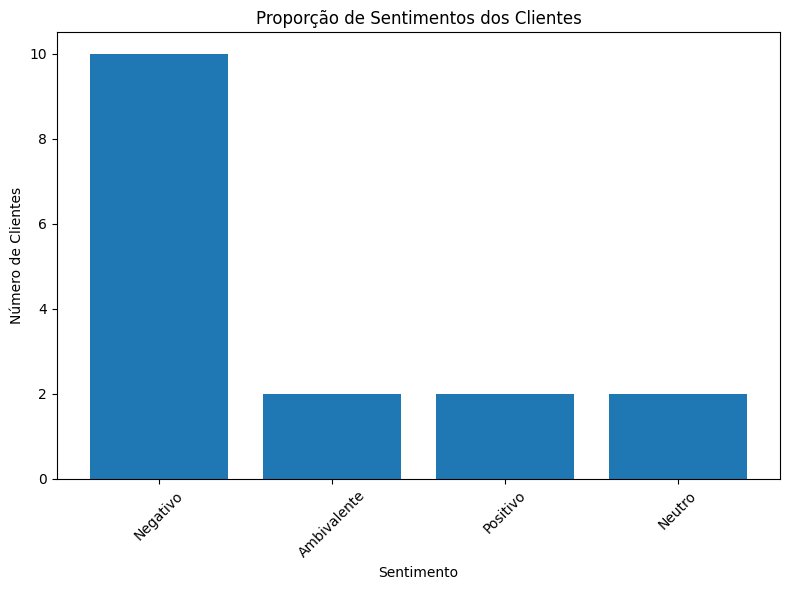

In [20]:
# Agrupa os dados por sentimento e conta a frequência de cada sentimento
sentimento_counts = df_agendas['Sentimento'].value_counts()

# Cria o gráfico de barras
plt.figure(figsize=(8, 6))
plt.bar(sentimento_counts.index, sentimento_counts.values)
plt.title('Proporção de Sentimentos dos Clientes')
plt.xlabel('Sentimento')
plt.ylabel('Número de Clientes')
plt.xticks(rotation=45) # Rotaciona os labels do eixo x para melhor visualização
plt.tight_layout() # Ajusta o layout para evitar que os labels se sobreponham

# Exibe o gráfico
plt.show()

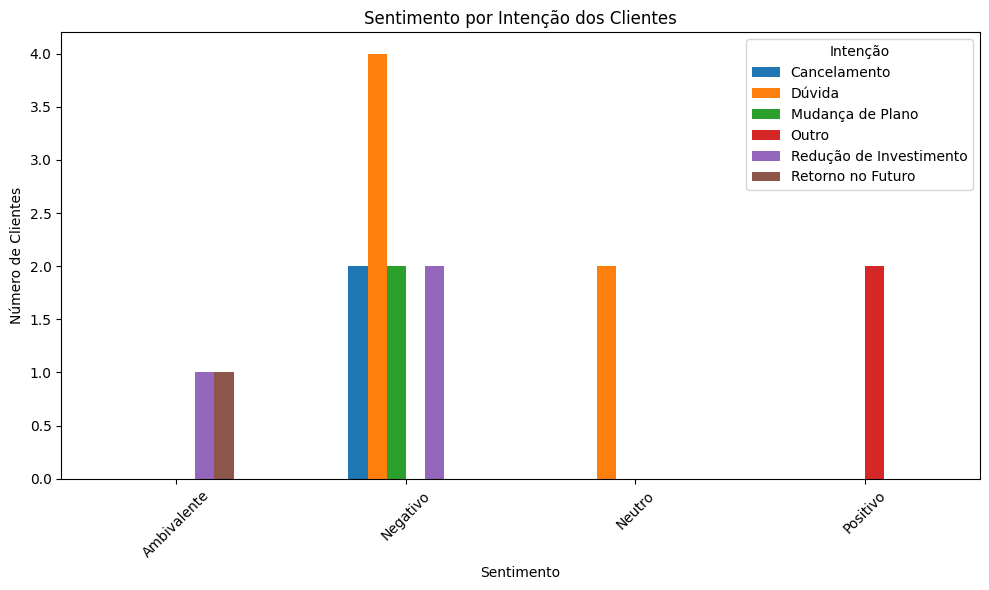

In [21]:
# Agrupa os dados por Sentimento e Intenção e conta a frequência
grouped_data = df_agendas.groupby(['Sentimento', 'Intenção']).size().unstack(fill_value=0)

# Cria o gráfico de barras
grouped_data.plot(kind='bar', figsize=(10, 6))

# Define o título do gráfico
plt.title('Sentimento por Intenção dos Clientes')

# Define os labels dos eixos
plt.xlabel('Sentimento')
plt.ylabel('Número de Clientes')

# Rotaciona os labels do eixo X para melhor visualização
plt.xticks(rotation=45)

# Ajusta o layout do gráfico
plt.tight_layout()

# Exibe o gráfico
plt.show()

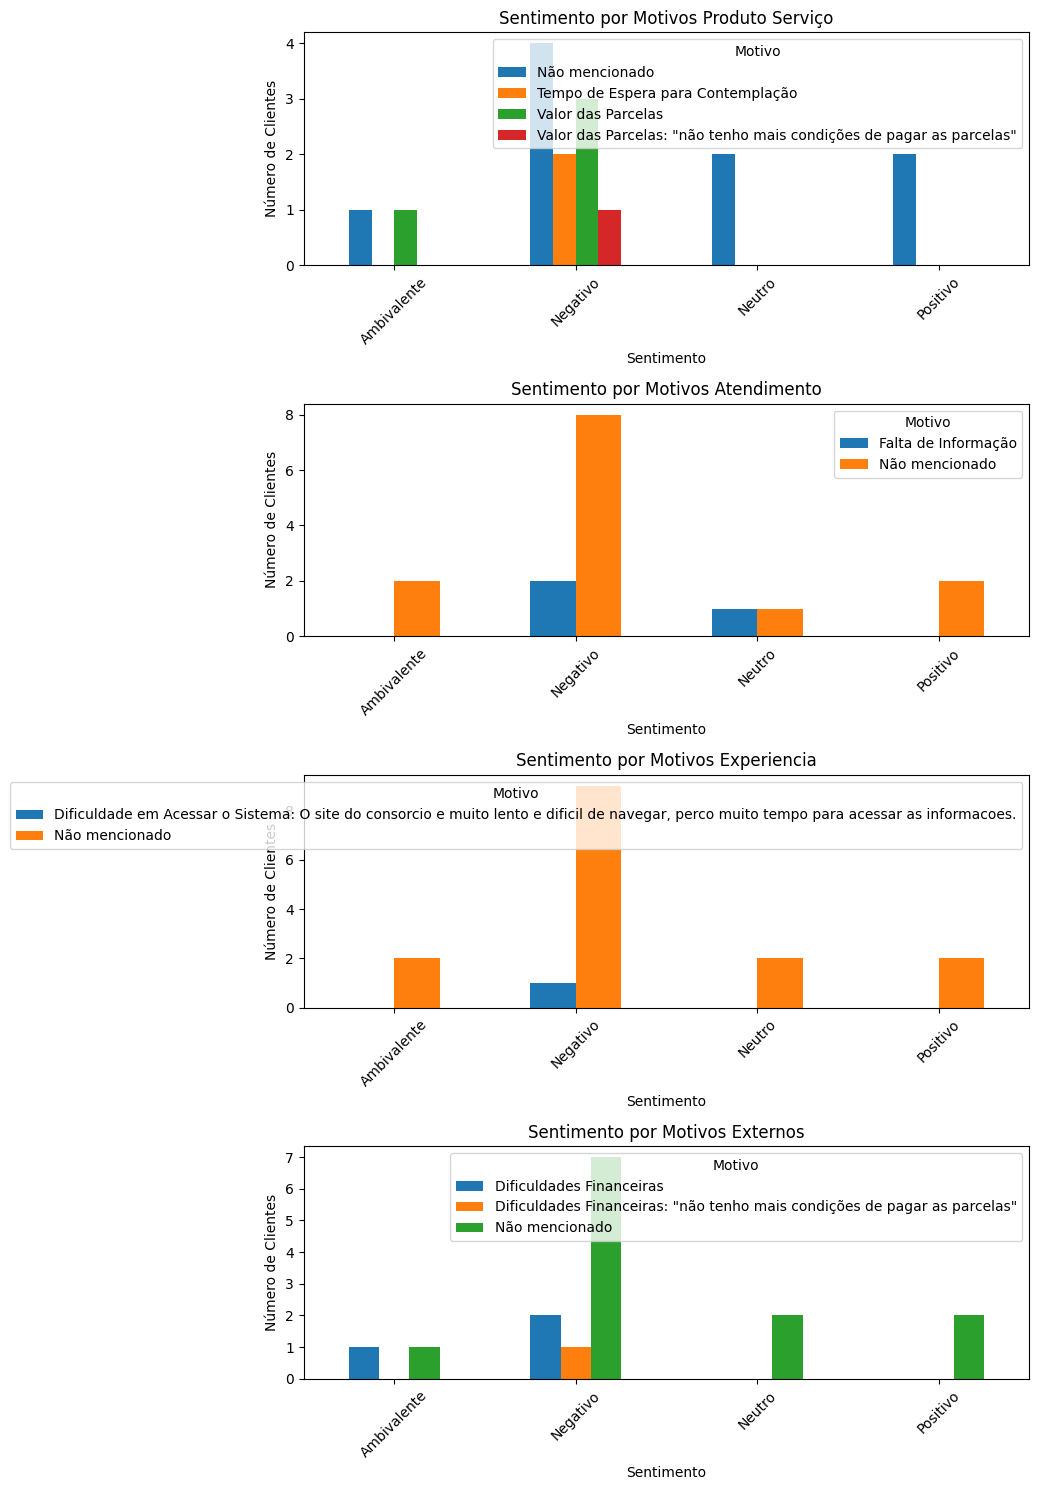

In [22]:
# Cria uma lista com os nomes das colunas de motivos
motivo_columns = ['Motivos_Produto_Serviço', 'Motivos_Atendimento', 'Motivos_Experiencia', 'Motivos_Externos']

# Cria um dicionário para armazenar os dados agrupados
data = {}

# Itera pelas colunas de motivos
for motivo_column in motivo_columns:
    # Agrupa os dados por Sentimento e Motivo e conta a frequência
    grouped_data = df_agendas.groupby(['Sentimento', motivo_column]).size().unstack(fill_value=0)
    
    # Adiciona os dados ao dicionário
    data[motivo_column] = grouped_data

# Plota os gráficos para cada motivo
fig, axes = plt.subplots(len(motivo_columns), 1, figsize=(10, 15))

# Itera pelas colunas de motivos
for i, motivo_column in enumerate(motivo_columns):
    # Plota o gráfico de barras para cada motivo
    data[motivo_column].plot(kind='bar', ax=axes[i], title=f'Sentimento por {motivo_column.replace("_", " ")}')

    # Ajusta os labels e título do gráfico
    axes[i].set_xlabel('Sentimento')
    axes[i].set_ylabel('Número de Clientes')
    axes[i].legend(title='Motivo')
    axes[i].tick_params(axis='x', rotation=45)

# Ajusta o layout da figura
plt.tight_layout()

# Exibe a figura com os gráficos
plt.show()

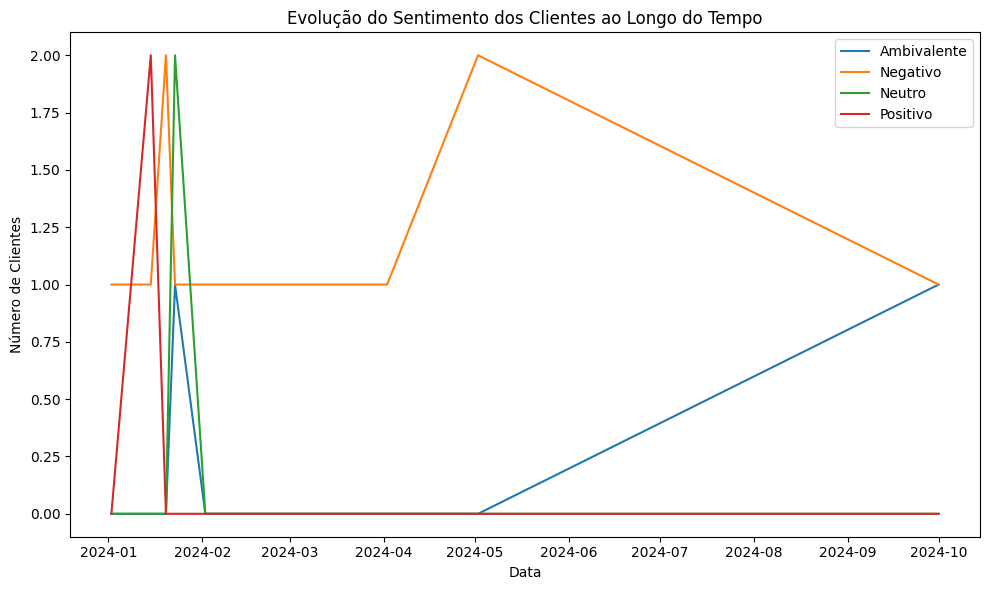

In [23]:
# Agrupa os dados por data e conta a frequência de cada sentimento
grouped_data = df_agendas.groupby('Data_Agenda')['Sentimento'].value_counts().unstack(fill_value=0)

# Cria o gráfico de linhas
plt.figure(figsize=(10, 6))
for sentimento in grouped_data.columns:
    plt.plot(grouped_data.index, grouped_data[sentimento], label=sentimento)

# Define o título do gráfico
plt.title('Evolução do Sentimento dos Clientes ao Longo do Tempo')

# Define os labels dos eixos
plt.xlabel('Data')
plt.ylabel('Número de Clientes')

# Adiciona a legenda
plt.legend()

# Ajusta o layout do gráfico
plt.tight_layout()

# Exibe o gráfico
plt.show()

2. Relatórios de Intenção:

    Proporção de Intenções: Calcular a proporção de clientes que expressaram cada intenção (Cancelamento, Redução de Investimento, Retorno no Futuro, Mudança de Plano, Dúvida, Outro).

    Intenção por Sentimento: Criar gráficos que mostrem a relação entre a intenção do cliente e seu sentimento (ex: Clientes com intenção de cancelamento que estão insatisfeitos com o serviço).

    Intenção por Motivo: Criar gráficos que mostrem a relação entre a intenção do cliente e os motivos específicos mencionados.

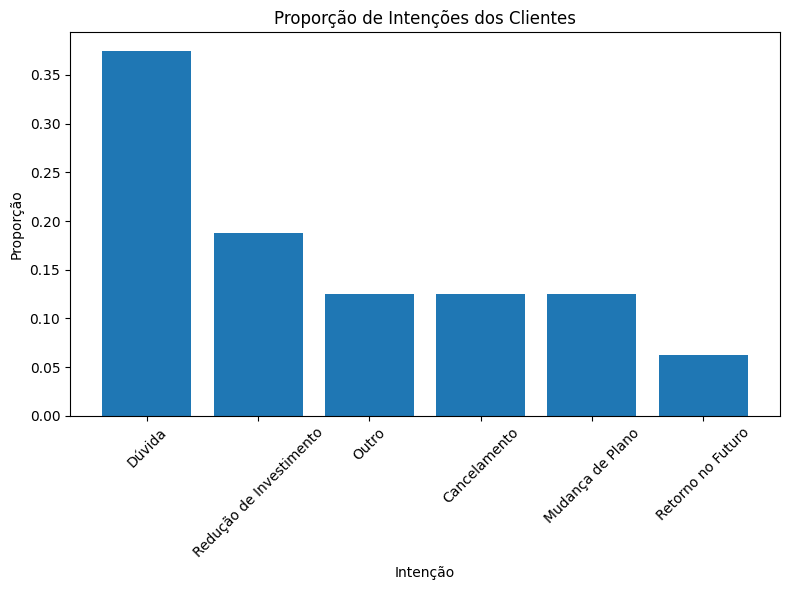

In [24]:
# Agrupa os dados por Intenção e conta a frequência de cada intenção
intencao_counts = df_agendas['Intenção'].value_counts()

# Calcula a proporção de cada intenção
intencao_proportions = intencao_counts / intencao_counts.sum()

# Cria o gráfico de barras
plt.figure(figsize=(8, 6))
plt.bar(intencao_proportions.index, intencao_proportions.values)
plt.title('Proporção de Intenções dos Clientes')
plt.xlabel('Intenção')
plt.ylabel('Proporção')
plt.xticks(rotation=45)  # Rotaciona os labels do eixo x para melhor visualização
plt.tight_layout()  # Ajusta o layout para evitar que os labels se sobreponham

# Exibe o gráfico
plt.show()

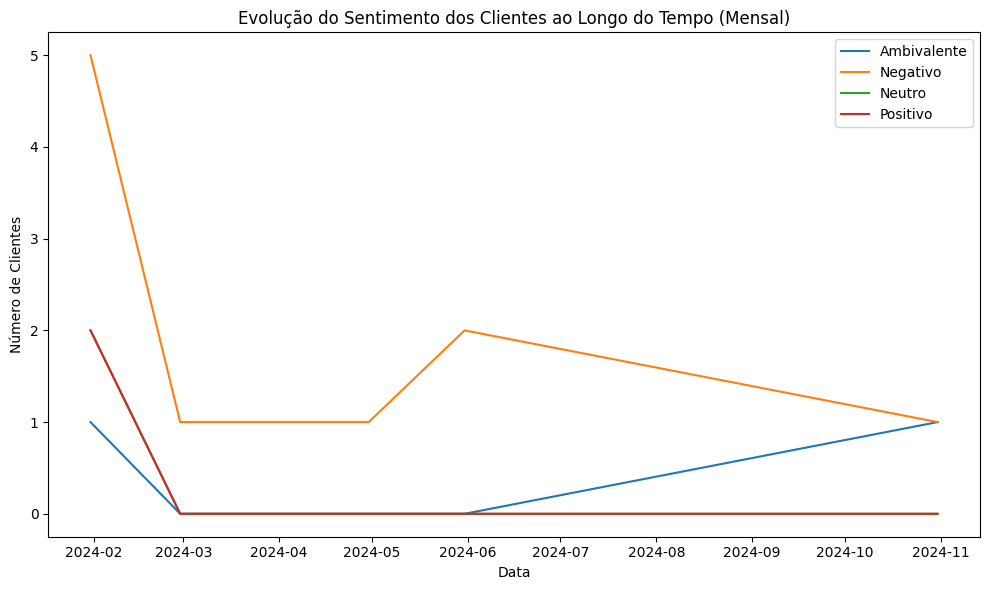

In [25]:
# Agrupa os dados por data e conta a frequência de cada sentimento
grouped_data = df_agendas.groupby(pd.Grouper(key='Data_Agenda', freq='M'))['Sentimento'].value_counts().unstack(fill_value=0)

# Cria o gráfico de linhas
plt.figure(figsize=(10, 6))
for sentimento in grouped_data.columns:
    plt.plot(grouped_data.index, grouped_data[sentimento], label=sentimento)

# Define o título do gráfico
plt.title('Evolução do Sentimento dos Clientes ao Longo do Tempo (Mensal)')

# Define os labels dos eixos
plt.xlabel('Data')
plt.ylabel('Número de Clientes')

# Adiciona a legenda
plt.legend()

# Ajusta o layout do gráfico
plt.tight_layout()

# Exibe o gráfico
plt.show()

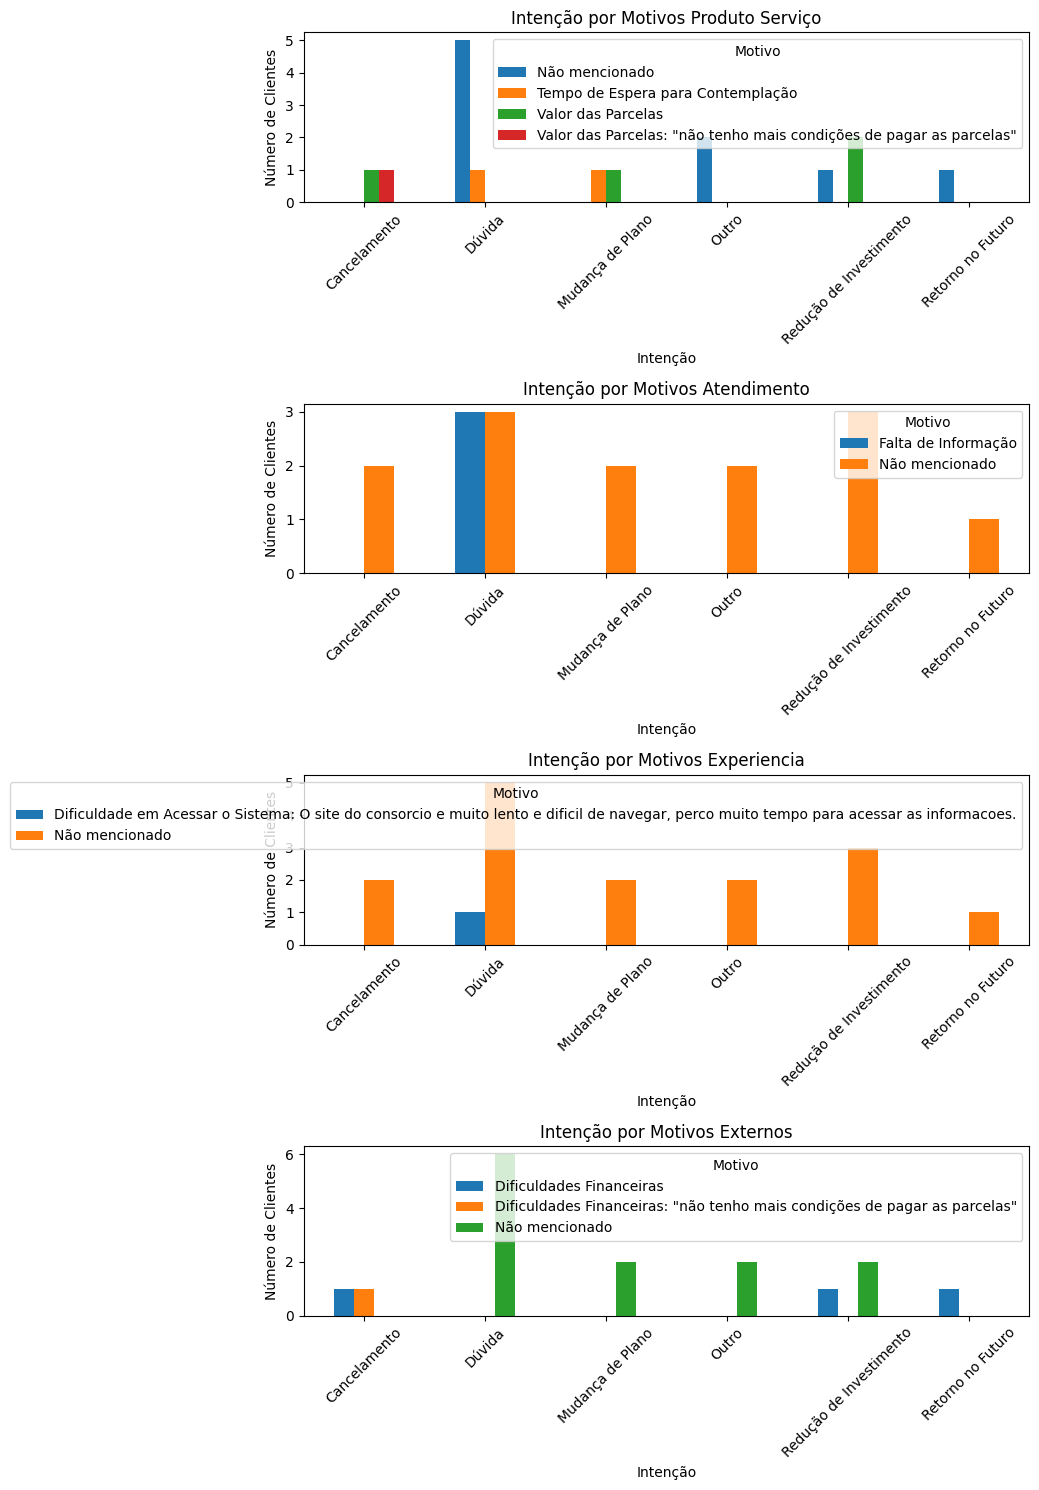

In [26]:
# Cria uma lista com os nomes das colunas de motivos
motivo_columns = ['Motivos_Produto_Serviço', 'Motivos_Atendimento', 'Motivos_Experiencia', 'Motivos_Externos']

# Cria um dicionário para armazenar os dados agrupados
data = {}

# Itera pelas colunas de motivos
for motivo_column in motivo_columns:
    # Agrupa os dados por Intenção e Motivo e conta a frequência
    grouped_data = df_agendas.groupby(['Intenção', motivo_column]).size().unstack(fill_value=0)
    
    # Adiciona os dados ao dicionário
    data[motivo_column] = grouped_data

# Plota os gráficos para cada motivo
fig, axes = plt.subplots(len(motivo_columns), 1, figsize=(10, 15))

# Itera pelas colunas de motivos
for i, motivo_column in enumerate(motivo_columns):
    # Plota o gráfico de barras para cada motivo
    data[motivo_column].plot(kind='bar', ax=axes[i], title=f'Intenção por {motivo_column.replace("_", " ")}')

    # Ajusta os labels e título do gráfico
    axes[i].set_xlabel('Intenção')
    axes[i].set_ylabel('Número de Clientes')
    axes[i].legend(title='Motivo')
    axes[i].tick_params(axis='x', rotation=45)

# Ajusta o layout da figura
plt.tight_layout()

# Exibe a figura com os gráficos
plt.show()

3. Relatórios de Motivos:

    Motivos Mais Comuns: Identificar os motivos mais frequentes mencionados pelos clientes, agrupados por categoria (Produto/Serviço, Atendimento, Experiência do Cliente, Externos).

    Motivos por Intenção: Criar gráficos que mostrem quais motivos são mais comuns em cada intenção (ex: motivos para cancelamento, motivos para redução de investimento).

    Motivos por Sentimento: Criar gráficos que mostrem quais motivos são mais comuns em cada sentimento (ex: motivos para clientes insatisfeitos, motivos para clientes satisfeitos).

C:\Users\rodrigo.goncalves\AppData\Local\Temp\3\ipykernel_21568\467327346.py:32: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  plt.tight_layout()


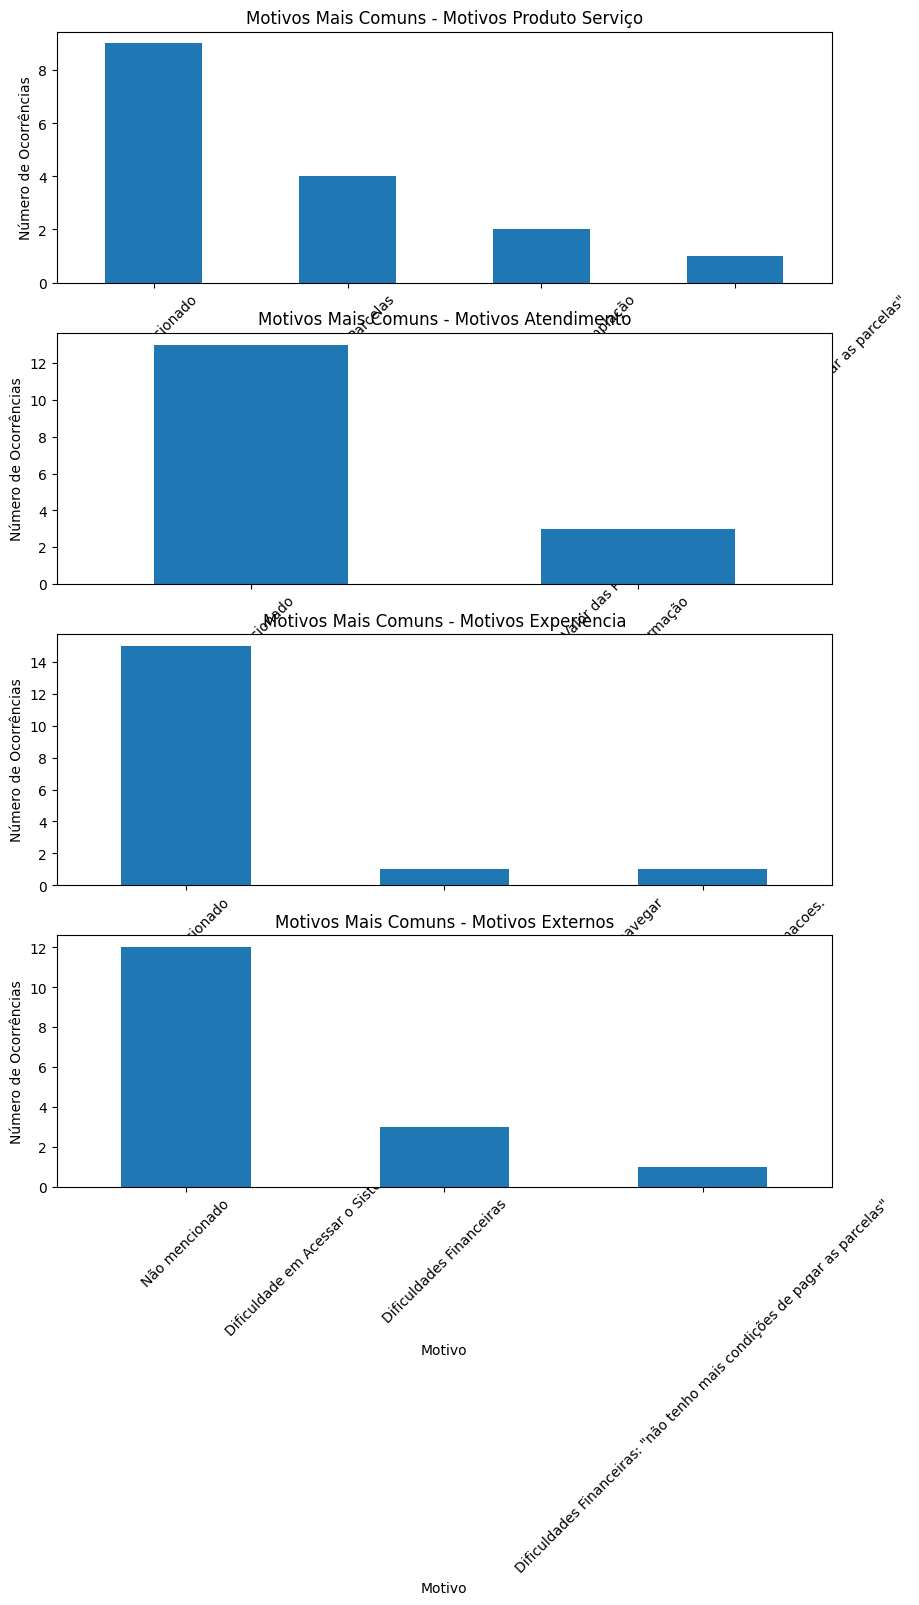

In [27]:
# Cria uma lista com os nomes das colunas de motivos
motivo_columns = ['Motivos_Produto_Serviço', 'Motivos_Atendimento', 'Motivos_Experiencia', 'Motivos_Externos']

# Cria um dicionário para armazenar os dados agrupados
data = {}

# Itera pelas colunas de motivos
for motivo_column in motivo_columns:
    # Concatena todos os motivos em uma única lista
    motivos = df_agendas[motivo_column].dropna().str.split(', ').sum()

    # Conta a frequência de cada motivo
    motivo_counts = pd.Series(motivos).value_counts()

    # Adiciona os dados ao dicionário
    data[motivo_column] = motivo_counts

# Plota os gráficos para cada motivo
fig, axes = plt.subplots(len(motivo_columns), 1, figsize=(10, 15))

# Itera pelas colunas de motivos
for i, motivo_column in enumerate(motivo_columns):
    # Plota o gráfico de barras para cada motivo
    data[motivo_column].plot(kind='bar', ax=axes[i], title=f'Motivos Mais Comuns - {motivo_column.replace("_", " ")}')

    # Ajusta os labels e título do gráfico
    axes[i].set_xlabel('Motivo')
    axes[i].set_ylabel('Número de Ocorrências')
    axes[i].tick_params(axis='x', rotation=45)

# Ajusta o layout da figura
plt.tight_layout()

# Exibe a figura com os gráficos
plt.show()

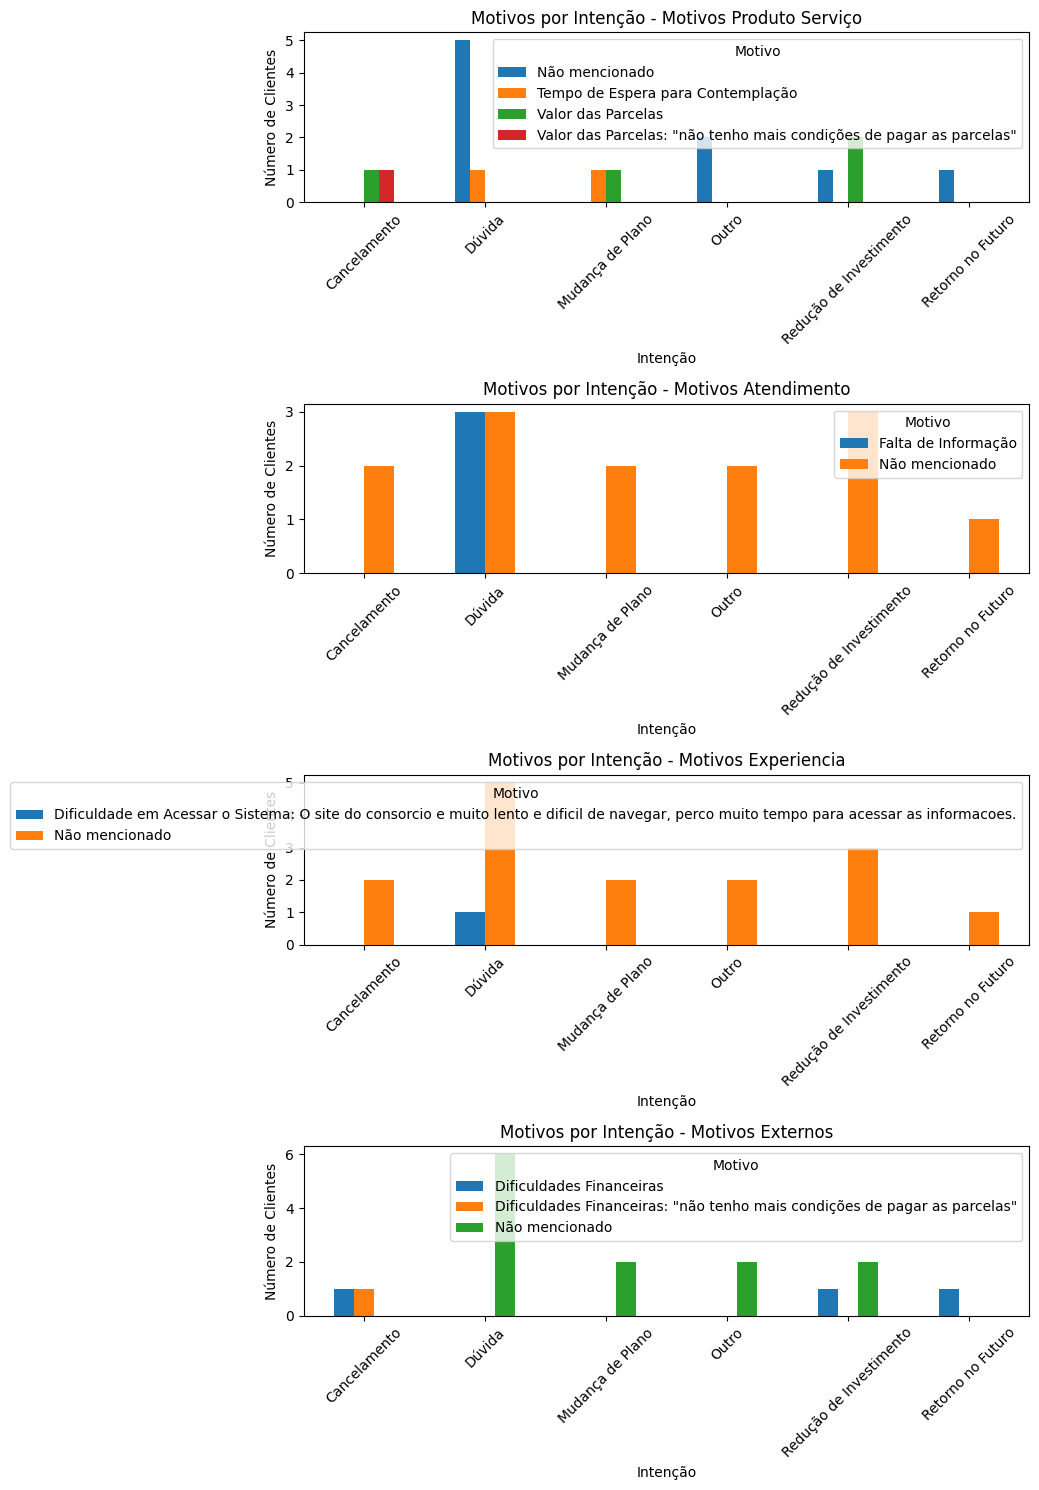

In [28]:
# Cria uma lista com os nomes das colunas de motivos
motivo_columns = ['Motivos_Produto_Serviço', 'Motivos_Atendimento', 'Motivos_Experiencia', 'Motivos_Externos']

# Cria um dicionário para armazenar os dados agrupados
data = {}

# Itera pelas colunas de motivos
for motivo_column in motivo_columns:
    # Agrupa os dados por Intenção e Motivo e conta a frequência
    grouped_data = df_agendas.groupby(['Intenção', motivo_column]).size().unstack(fill_value=0)

    # Adiciona os dados ao dicionário
    data[motivo_column] = grouped_data

# Plota os gráficos para cada motivo
fig, axes = plt.subplots(len(motivo_columns), 1, figsize=(10, 15))

# Itera pelas colunas de motivos
for i, motivo_column in enumerate(motivo_columns):
    # Plota o gráfico de barras para cada motivo
    data[motivo_column].plot(kind='bar', ax=axes[i], title=f'Motivos por Intenção - {motivo_column.replace("_", " ")}')

    # Ajusta os labels e título do gráfico
    axes[i].set_xlabel('Intenção')
    axes[i].set_ylabel('Número de Clientes')
    axes[i].legend(title='Motivo')
    axes[i].tick_params(axis='x', rotation=45)

# Ajusta o layout da figura
plt.tight_layout()

# Exibe a figura com os gráficos
plt.show()

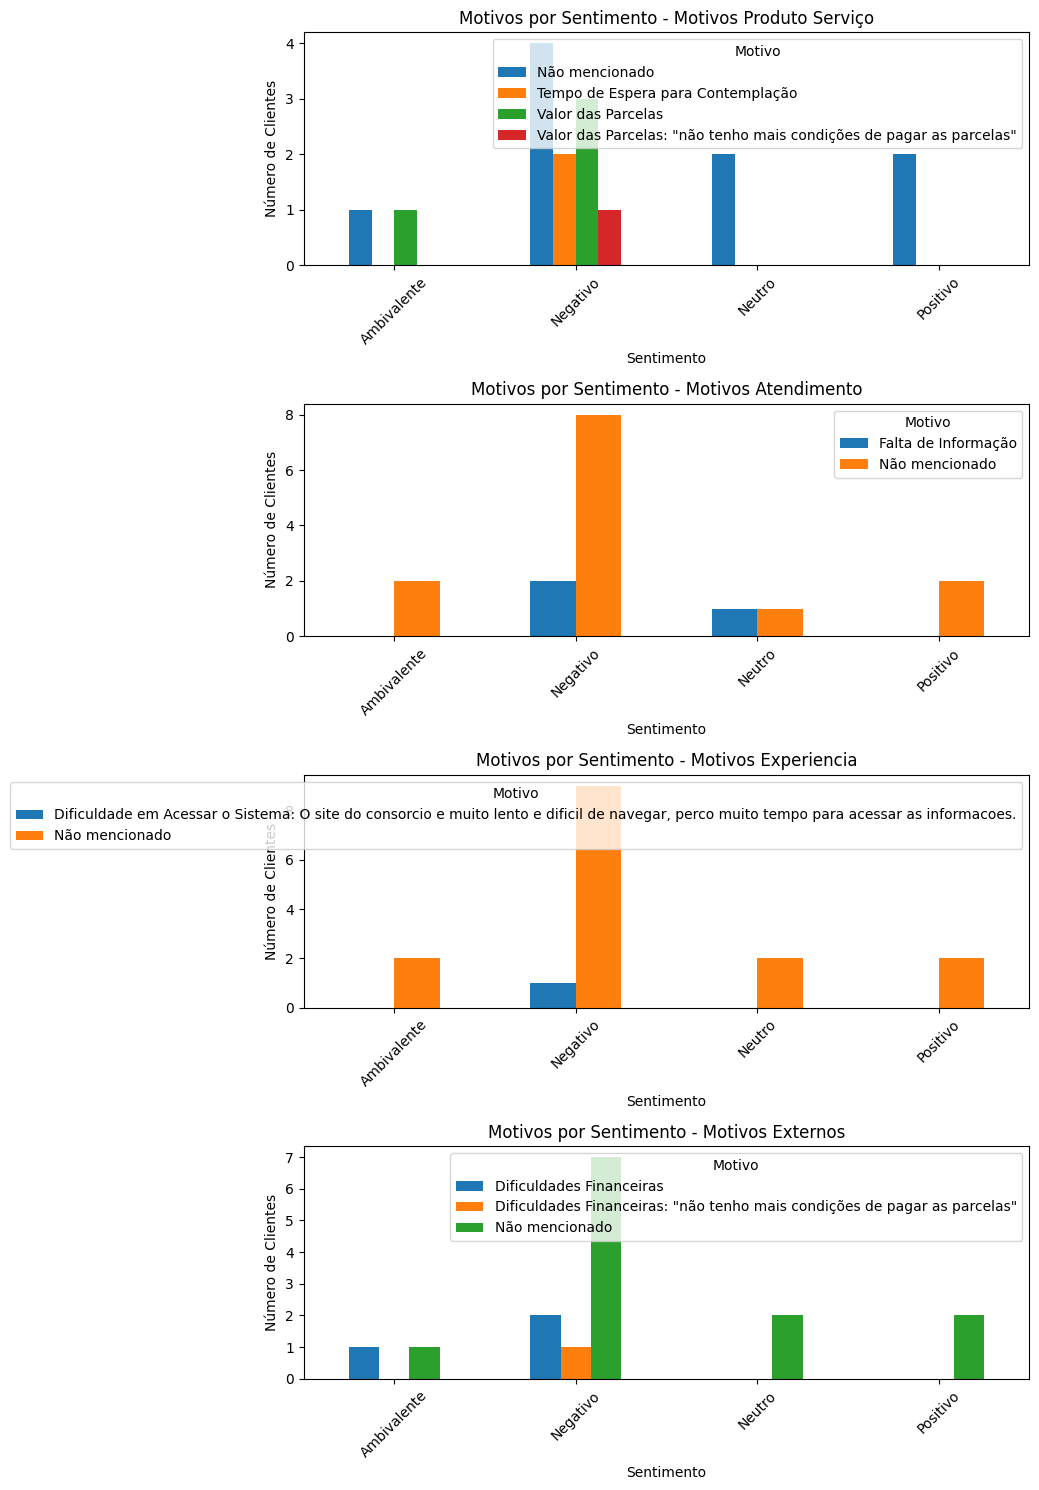

In [29]:
# Cria uma lista com os nomes das colunas de motivos
motivo_columns = ['Motivos_Produto_Serviço', 'Motivos_Atendimento', 'Motivos_Experiencia', 'Motivos_Externos']

# Cria um dicionário para armazenar os dados agrupados
data = {}

# Itera pelas colunas de motivos
for motivo_column in motivo_columns:
    # Agrupa os dados por Sentimento e Motivo e conta a frequência
    grouped_data = df_agendas.groupby(['Sentimento', motivo_column]).size().unstack(fill_value=0)

    # Adiciona os dados ao dicionário
    data[motivo_column] = grouped_data

# Plota os gráficos para cada motivo
fig, axes = plt.subplots(len(motivo_columns), 1, figsize=(10, 15))

# Itera pelas colunas de motivos
for i, motivo_column in enumerate(motivo_columns):
    # Plota o gráfico de barras para cada motivo
    data[motivo_column].plot(kind='bar', ax=axes[i], title=f'Motivos por Sentimento - {motivo_column.replace("_", " ")}')

    # Ajusta os labels e título do gráfico
    axes[i].set_xlabel('Sentimento')
    axes[i].set_ylabel('Número de Clientes')
    axes[i].legend(title='Motivo')
    axes[i].tick_params(axis='x', rotation=45)

# Ajusta o layout da figura
plt.tight_layout()

# Exibe a figura com os gráficos
plt.show()

Análise de Grupos:
Agrupamento por Sentimento: Agrupar os clientes em grupos com base no sentimento expresso (ex: clientes satisfeitos, clientes insatisfeitos).

    Agrupamento por Intenção: Agrupar os clientes em grupos com base na intenção expressa (ex: clientes que desejam cancelar, clientes que desejam reduzir o investimento).

    Agrupamento por Motivos: Agrupar os clientes em grupos com base nos motivos mencionados (ex: clientes que reclamam do valor das parcelas, clientes que reclamam da qualidade do atendimento).

In [30]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Carrega o DataFrame com as informações das agendas
df_agendas = pd.read_csv('agendas_analisadas.csv', parse_dates=['Data de Adesão'])

# Seleciona as colunas numéricas para o agrupamento
features = ['Idade', 'Valor Renda', 'Quantidade de Compras', 'NPS', 'Quantidade de Reclamações', 'Valor da Parcela']
X = df_agendas[features]

# Padroniza os dados
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Define o número de clusters (3 neste caso - pode ser ajustado)
n_clusters = 3

# Cria o modelo KMeans
kmeans = KMeans(n_clusters=n_clusters, random_state=42)

# Treina o modelo
kmeans.fit(X_scaled)

# Adiciona a coluna de cluster ao DataFrame
df_agendas['Cluster'] = kmeans.labels_

# Agrupa os dados por cluster e calcula a proporção de cada sentimento
grouped_data = df_agendas.groupby('Cluster')['Sentimento'].value_counts(normalize=True).unstack(fill_value=0)

# Plota o gráfico de barras
grouped_data.plot(kind='bar', figsize=(10, 6))

# Define o título do gráfico
plt.title('Proporção de Sentimentos por Cluster')

# Define os labels dos eixos
plt.xlabel('Cluster')
plt.ylabel('Proporção')

# Rotaciona os labels do eixo X para melhor visualização
plt.xticks(rotation=45)

# Ajusta o layout do gráfico
plt.tight_layout()

# Exibe o gráfico
plt.show()

ValueError: Missing column provided to 'parse_dates': 'Data de Adesão'

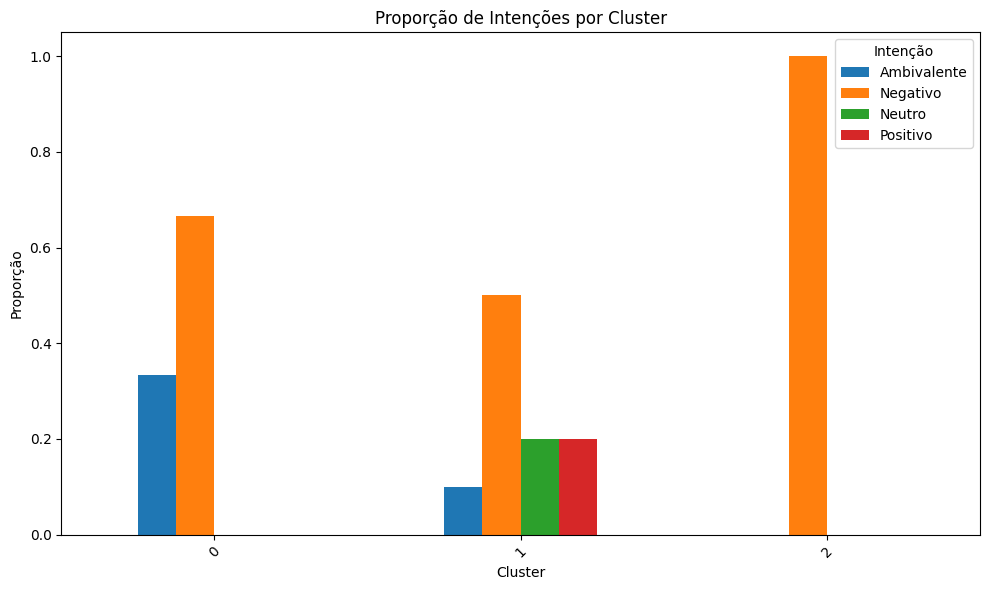

In [ ]:
# Seleciona as colunas numéricas para o agrupamento
features = ['Idade', 'Valor Renda', 'Quantidade de Compras', 'NPS', 'Quantidade de Reclamações', 'Valor da Parcela']
X = df_agendas[features]

# Padroniza os dados
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Define o número de clusters (3 neste caso - pode ser ajustado)
n_clusters = 3

# Cria o modelo KMeans
kmeans = KMeans(n_clusters=n_clusters, random_state=42)

# Treina o modelo
kmeans.fit(X_scaled)

# Adiciona a coluna de cluster ao DataFrame
df_agendas['Cluster'] = kmeans.labels_

# Agrupa os dados por cluster e calcula a proporção de cada intenção
grouped_data = df_agendas.groupby('Cluster')['Intenção'].value_counts(normalize=True).unstack(fill_value=0)

# Plota o gráfico de barras
grouped_data.plot(kind='bar', figsize=(10, 6))

# Define o título do gráfico
plt.title('Proporção de Intenções por Cluster')

# Define os labels dos eixos
plt.xlabel('Cluster')
plt.ylabel('Proporção')

# Rotaciona os labels do eixo X para melhor visualização
plt.xticks(rotation=45)

# Ajusta o layout do gráfico
plt.tight_layout()

# Exibe o gráfico
plt.show()


In [ ]:
# Cria uma lista com os nomes das colunas de motivos
motivo_columns = ['Motivos_Produto_Serviço', 'Motivos_Atendimento', 'Motivos_Experiencia', 'Motivos_Externos']

# Cria um DataFrame com as colunas de motivos, utilizando one-hot encoding
motivos_df = pd.get_dummies(df_agendas[motivo_columns], prefix_sep='_', dummy_na=True,  prefix=['Produto', 'Atendimento', 'Experiencia', 'Externo'])

# Seleciona as colunas numéricas para o agrupamento
features = ['Idade', 'Valor Renda', 'Quantidade de Compras', 'NPS', 'Quantidade de Reclamações', 'Valor da Parcela']
features.extend(motivos_df.columns)
X = df_agendas[features]

# Padroniza os dados
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Define o número de clusters (3 neste caso - pode ser ajustado)
n_clusters = 3

# Cria o modelo KMeans
kmeans = KMeans(n_clusters=n_clusters, random_state=42)

# Treina o modelo
kmeans.fit(X_scaled)

# Adiciona a coluna de cluster ao DataFrame
df_agendas['Cluster'] = kmeans.labels_

# Agrupa os dados por cluster e calcula a proporção de cada motivo
grouped_data = df_agendas.groupby('Cluster')[motivo_columns].apply(lambda x: x.value_counts(normalize=True)).unstack(fill_value=0)

# Plota o gráfico de barras
grouped_data.plot(kind='bar', figsize=(10, 6))

# Define o título do gráfico
plt.title('Proporção de Motivos por Cluster')

# Define os labels dos eixos
plt.xlabel('Cluster')
plt.ylabel('Proporção')

# Rotaciona os labels do eixo X para melhor visualização
plt.xticks(rotation=45)

# Ajusta o layout do gráfico
plt.tight_layout()

# Exibe o gráfico
plt.show()

KeyError: "['Produto_Não mencionado', 'Produto_Tempo de Espera para Contemplação', 'Produto_Valor das Parcelas', 'Produto_nan', 'Atendimento_Falta de Informação', 'Atendimento_Não mencionado', 'Atendimento_nan', 'Experiencia_Dificuldade em Acessar o Sistema (O site do consórcio é muito lento e difícil de navegar)', 'Experiencia_Não mencionado', 'Experiencia_O sistema online do consórcio é muito fácil de usar.', 'Experiencia_nan', 'Externo_Dificuldades Financeiras', 'Externo_Não mencionado', 'Externo_nan'] not in index"

In [32]:
print(df_agendas.head())

                                             agendas   Sentimento  \
0  Estou muito satisfeito com o atendimento, mas ...  Ambivalente   
1  Estou decepcionado com a demora para ser conte...     Negativo   
2  Amei o carro que consegui no consórcio, a expe...     Positivo   
3  A empresa não me respondeu sobre o meu pedido ...     Negativo   
4  O sistema online do consórcio é muito fácil de...     Positivo   

      Intenção            Motivos_Produto_Serviço  Motivos_Atendimento  \
0  Ambivalente                 Valor das Parcelas       Não mencionado   
1     Negativo  Tempo de Espera para Contemplação  Falta de Informação   
2     Positivo                     Não mencionado       Não mencionado   
3     Negativo                     Não mencionado  Falta de Informação   
4     Positivo                     Não mencionado       Não mencionado   

                                 Motivos_Experiencia Motivos_Externos  \
0                                     Não mencionado   Não menciona